## Demonstrate a reconstruction attack by regression analysis on random aggregated sums

In [87]:
##
##  regressionAttack.r
##
##  demonstrate reconstruction attack by regression on sums of subsets
##  cycle over different query sizes and show average correct reconstruction rate
##
##  jH 2025.2.03
##

#### Parameters ####
set.seed(123)
n <- 100        	# Dataset size
m.trials <- 70  	# Number of queries
q.size <- 30    	# Subset size
addPrior <- FALSE	# Whether to add priors
k.seq <- seq(from=40, to=250, by=3) # Sequence of query sizes
sims <- 20#50							# Number of iterations of each query size
addConstant <-FALSE


## Get Data

In [88]:
## If we wanted to simulate data, we might try:
#my.pi <- 0.2
#sensitiveData <- rbinom(n, size=1, prob=my.pi)

## But here we read it from the repository:

library("foreign")
pums <- read.csv(file="https://raw.githubusercontent.com/opendp/cs208/main/spring2025/data/PUMS5extract10000.csv")
var <- "latino"    											# or also try "educ" for multivalued education scale
my.pi <- mean(pums[,var])
sampleIndex <- sample(x=1:nrow(pums), size=n, replace = FALSE )
sensitiveData <- pums[sampleIndex, var]

## Here is our seemingly innocuous aggregated query

In [89]:
query <- function(n, data, sd=1){
	index <- sample(1:length(data), n)
	subset <- data[index]
	sum <- round(sum(subset)/5)*5
	#sum <- sum(subset) + rnorm(n=1, mean=0, sd=sd)

    return(list(sum=sum, index=index))
}


## Simulate an attack

In [90]:

#### Here we run our query repeatedly and record results ####
history <- matrix(NA, nrow=m.trials, ncol=n+1)            # a matrix to store results in

for(i in 1:m.trials){
  res <- query(n=q.size, data=sensitiveData, sd=0.25)
  indicator <- 1:n %in% res$index                         # convert indices into a series of boolean/dummy variables
  indicator <- as.numeric(indicator)
  history[i,] <- c(res$sum, indicator)                    # save into our results matrix
}


#### Add (data augmentation) prior ####

if(addPrior){
	s <- max(100 - m.trials, 0)
	x <- matrix(rbinom(s*n, size=1, prob=0.5), nrow=s, ncol=n)
	y <- apply(x, 1, sum)*my.pi

	prior <- matrix(NA, nrow=s, ncol=n+1)
	prior[,1] <- y
	prior[,2:(n+1)] <- x
	history <- rbind(history, prior)
}


#### Convert matrix into data frame
xnames <- paste("x", 1:n, sep="")
varnames<- c("y", xnames)
releaseData <- as.data.frame(history)                     # convert matrix into data frame
names(releaseData) <- varnames


#### Run a linear regression ####
formula <- paste(xnames, collapse=" + ")                  # construct the formula, y ~ x1 ... xn -1
formula <- paste("y ~ ", formula, "-1")
formula <- as.formula(formula)
print(formula)

output <- lm(formula, data=releaseData)                   # run the regression
estimates <- output$coef                                  # save the estimates


y ~ x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9 + x10 + x11 + 
    x12 + x13 + x14 + x15 + x16 + x17 + x18 + x19 + x20 + x21 + 
    x22 + x23 + x24 + x25 + x26 + x27 + x28 + x29 + x30 + x31 + 
    x32 + x33 + x34 + x35 + x36 + x37 + x38 + x39 + x40 + x41 + 
    x42 + x43 + x44 + x45 + x46 + x47 + x48 + x49 + x50 + x51 + 
    x52 + x53 + x54 + x55 + x56 + x57 + x58 + x59 + x60 + x61 + 
    x62 + x63 + x64 + x65 + x66 + x67 + x68 + x69 + x70 + x71 + 
    x72 + x73 + x74 + x75 + x76 + x77 + x78 + x79 + x80 + x81 + 
    x82 + x83 + x84 + x85 + x86 + x87 + x88 + x89 + x90 + x91 + 
    x92 + x93 + x94 + x95 + x96 + x97 + x98 + x99 + x100 - 1


## Plot Results

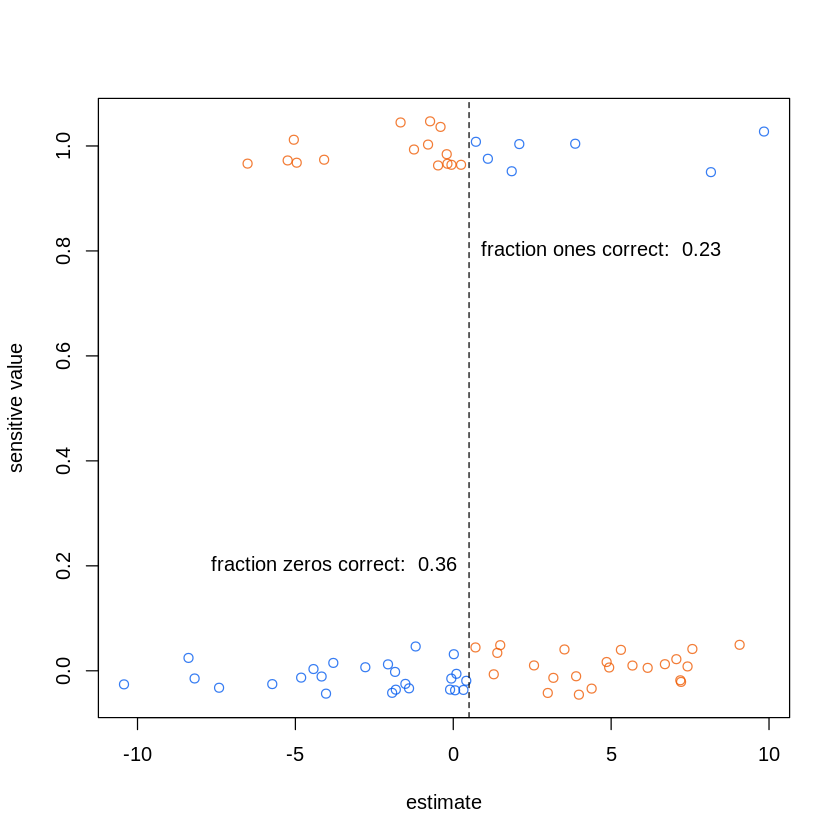

In [91]:
delta <- 0.05                                             # Slight disturbance to add
jitterx <- runif(n=n, min=-delta, max=delta)
jittery <- runif(n=n, min=-delta, max=delta)
semi.blue <- rgb(0,90,239,200,maxColorValue=255)          # Slightly transparent colors
semi.red  <- rgb(239,90,0,200,maxColorValue=255)
col.values <- c(semi.red, semi.blue)

true.1 <- (estimates>0.5) & (sensitiveData==1)            # Correctly predicted values
true.0 <- (estimates<0.5) & (sensitiveData==0)
true1.frac <- round(sum(true.1, na.rm=TRUE)/sum(sensitiveData)*100)/100
true0.frac <- round(sum(true.0, na.rm=TRUE)/sum(1-sensitiveData)*100)/100
truth.col<-1 + true.1 + true.0

plot(x=estimates + jitterx, y=sensitiveData + jittery, xlab="estimate", ylab="sensitive value", col=col.values[truth.col])    # Plot reconstruction against actual sensitive data
abline(v=0.5, lty=2)
text(x=0.5, y=0.8, labels=paste("fraction ones correct: ", true1.frac), pos=4)
text(x=0.5, y=0.2, labels=paste("fraction zeros correct: ", true0.frac), pos=2)


## Loop over query size to show

In [92]:

historyQuerySize <- matrix(NA, nrow=length(k.seq), ncol=3)

for(j in 1:length(k.seq)){       # Loop over number of queries
	if(round((j-1)/10) == ((j-1)/10)) cat(j, "of", length(k.seq), "\n")  # This is a longer simulation, so nice to have screen output showing progress
	m.trials <- k.seq[j]

	historyTemp <- matrix(NA, nrow=sims, ncol=2)

	for(k in 1:sims){

		#### Here we run our query repeatedly and record results ####
		history <- matrix(NA, nrow=m.trials, ncol=n+1)            	# a matrix to store simulation results in

		for(i in 1:m.trials){
			res <- query(n=q.size, data=sensitiveData, sd=0.25)
			indicator <- 1:n %in% res$index                         # convert indices into a series of boolean/dummy variables
			indicator <- as.numeric(indicator)
			history[i,] <- c(res$sum, indicator)                    # save into our results matrix
		}

		#### Add (data augmentation) prior ####

		if(addPrior){
			s <- max(n - m.trials, 0)
			x <- matrix(rbinom(s*n, size=1, prob=0.5), nrow=s, ncol=n)
			y <- apply(x, 1, sum)*my.pi
			prior <- matrix(NA, nrow=s, ncol=n+1)
			prior[,1] <- y
			prior[,2:(n+1)] <- x
			history <- rbind(history, prior)
		}

		#### Convert matrix into data frame ####
		xnames <- paste("x", 1:n, sep="")
		varnames<- c("y", xnames)
		releaseData <- as.data.frame(history)                     # convert matrix into data frame
		names(releaseData) <- varnames


		#### Run a linear regression ####
		formula <- paste(xnames, collapse=" + ")                  # construct the formula, y ~ x1 ... xn -1
		if(addConstant){
			formula <- paste("y ~ ", formula)
		} else {
			formula <- paste("y ~ ", formula, "-1")
		}

		formula <- as.formula(formula)

		output <- lm(formula, data=releaseData)                   # run the regression
		if(addConstant){
			estimates <- output$coef[-1]                          # save the estimates
		} else {
			estimates <- output$coef                              # save the estimates
		}

		#### Determine which observations correctly reconstructed ####
		true.1 <- (estimates>0.5) & (sensitiveData==1)            # Correctly predicted values
		true.0 <- (estimates<0.5) & (sensitiveData==0)
		true1.frac <- round(sum(true.1, na.rm=TRUE)/sum(sensitiveData)*1000)/1000
		true0.frac <- round(sum(true.0, na.rm=TRUE)/sum(1-sensitiveData)*1000)/1000

		historyTemp[k,1] <- true1.frac   # Store the true fractions for this simulations
		historyTemp[k,2] <- true0.frac

	}

	historyQuerySize[j,1] <- k.seq[j]     # Store the average true fraction across simulations for this query size
	historyQuerySize[j,2] <- mean(historyTemp[,1])
	historyQuerySize[j,3] <- mean(historyTemp[,2])

}


1 of 71 
11 of 71 
21 of 71 
31 of 71 
41 of 71 
51 of 71 
61 of 71 
71 of 71 


## Plot Results

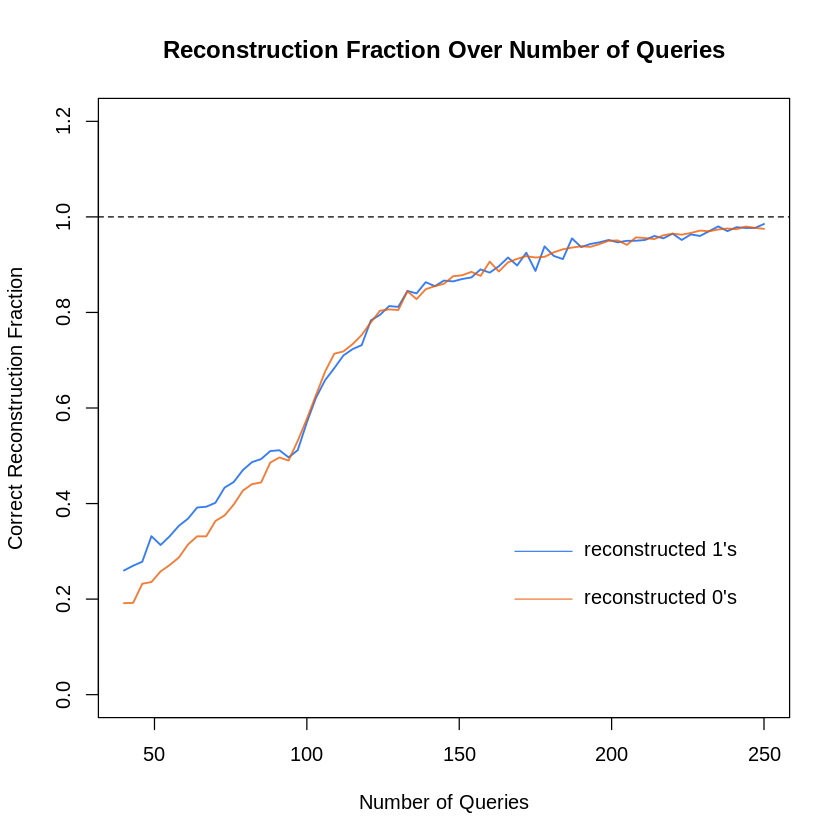

In [93]:
semi.blue <- rgb(0,90,239,200,maxColorValue=255)          # Slightly transparent colors
semi.red  <- rgb(239,90,0,200,maxColorValue=255)
col.values <- c(semi.red, semi.blue)

plot(x=historyQuerySize[,1], y=historyQuerySize[,2], ylim=c(0,1.2), type="l", lwd=1.5, col=semi.blue, main="Reconstruction Fraction Over Number of Queries", ylab="Correct Reconstruction Fraction", xlab="Number of Queries")
lines(x=historyQuerySize[,1], y=historyQuerySize[,3], type="l", lwd=1.5, col=semi.red)
abline(h=1, lty=2)

legx <- k.seq[round(length(k.seq)*.7)]

lines(x=c(legx, legx*.9), y=c(0.2,0.2), col=semi.red)
lines(x=c(legx, legx*.9), y=c(0.3,0.3), col=semi.blue)

text(x=legx, y=0.2, pos=4, labels="reconstructed 0's")
text(x=legx, y=0.3, pos=4, labels="reconstructed 1's")
